In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import h5py
import pandas as pd
import numpy as np
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn import preprocessing


In [2]:
f = h5py.File('processed-pythia82-lhc13-all-pt1-50k-r1_h022_e0175_t220_nonu_withPars_truth.z', 'r')
treeArray = f['t_allpar_new'][()]

In [3]:
features = ['j1_etarot','j1_phirot','j1_ptrel','j_index']
labels = ['j_g','j_q','j_w','j_z','j_t','j_index']

In [4]:
features_df = pd.DataFrame(treeArray,columns=list(set(features)))
labels_df = pd.DataFrame(treeArray,columns=list(set(labels)))
df = pd.concat([features_df,labels_df],axis=1)
df = df.drop_duplicates()


In [5]:

MaxParticles = 100
BinsX = 40
MinX = -0.8
MaxX =  0.8
BinsY = 40
MinY = -1.0
MaxY = 1.0

# Convert to nparray
labels_df = labels_df.drop_duplicates()
features_val = features_df.drop(['j_index'],axis=1).values
labels_val = labels_df.drop(['j_index'],axis=1).values

features_2dval = np.zeros((len(labels_df), BinsX, BinsY, 1))
for i in range(0, len(labels_df)):
    features_df_i = features_df[features_df['j_index'] == labels_df['j_index'].iloc[i]]
    index_values = features_df_i.index.values

    xbins = np.linspace(MinX, MaxX, BinsX + 1)
    ybins = np.linspace(MinY, MaxY, BinsY + 1)

    x = features_df_i[features[0]]
    y = features_df_i[features[1]]
    w = features_df_i[features[2]]

    hist, xedges, yedges = np.histogram2d(x, y, weights=w, bins=(xbins, ybins))

    for ix in range(0, BinsX):
        for iy in range(0, BinsY):
            features_2dval[i, ix, iy, 0] = hist[ix, iy]
features_val = features_2dval
X_train_val, X_test, y_train_val, y_test = train_test_split(features_val, labels_val, test_size=0.2,
                                                                random_state=42)


In [6]:
l1Reg = 0.0001

In [7]:
model = models.Sequential()
model.add(layers.Conv2D(filters=8, kernel_size=(11,11), strides=1, padding='same',
               kernel_initializer='he_normal', use_bias=True, name='conv1_relu_1',
               activation = 'relu', kernel_regularizer=l1(l1Reg),input_shape=(40,40, 1)))
model.add(layers.Conv2D(filters=4, kernel_size=(3,3), strides=2, padding='same',
               kernel_initializer='he_normal', use_bias=True, name='conv1_relu_2',
               activation = 'relu', kernel_regularizer=l1(l1Reg)))
model.add(layers.Conv2D(filters=2, kernel_size=(3,3), strides=2, padding='same',
               kernel_initializer='he_normal', use_bias=True, name='conv1_relu_3',
               activation = 'relu', kernel_regularizer=l1(l1Reg)))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(5, activation='softmax', kernel_initializer='lecun_uniform', 
                        name='output_softmax', kernel_regularizer=l1(l1Reg)))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_relu_1 (Conv2D)        (None, 40, 40, 8)         976       
_________________________________________________________________
conv1_relu_2 (Conv2D)        (None, 20, 20, 4)         292       
_________________________________________________________________
conv1_relu_3 (Conv2D)        (None, 10, 10, 2)         74        
_________________________________________________________________
flatten (Flatten)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                6432      
_________________________________________________________________
output_softmax (Dense)       (None, 5)                 165       
Total params: 7,939
Trainable params: 7,939
Non-trainable params: 0
______________________________________________________

In [8]:
learningRate = 1e-4
adam = Adam(lr=learningRate)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
history = model.fit(X_train_val, y_train_val, epochs = 25, 
                    validation_split = 0.25, shuffle = True, callbacks = None)

Epoch 1/25
466/466 [==============================] - 14s 31ms/step - loss: 0.2124 - accuracy: 0.9531 - val_loss: 0.0278 - val_accuracy: 0.9996
Epoch 2/25
466/466 [==============================] - 14s 29ms/step - loss: 0.0213 - accuracy: 0.9997 - val_loss: 0.0255 - val_accuracy: 0.9994
Epoch 3/25
466/466 [==============================] - 13s 29ms/step - loss: 0.0187 - accuracy: 0.9998 - val_loss: 0.0231 - val_accuracy: 0.9996
Epoch 4/25
466/466 [==============================] - 13s 29ms/step - loss: 0.0168 - accuracy: 0.9997 - val_loss: 0.0216 - val_accuracy: 0.9996
Epoch 5/25
466/466 [==============================] - 13s 29ms/step - loss: 0.0152 - accuracy: 0.9995 - val_loss: 0.0220 - val_accuracy: 0.9992
Epoch 6/25
466/466 [==============================] - 14s 31ms/step - loss: 0.0134 - accuracy: 0.9999 - val_loss: 0.0182 - val_accuracy: 0.9992
Epoch 7/25
466/466 [==============================] - 13s 29ms/step - loss: 0.0146 - accuracy: 0.9990 - val_loss: 0.0180 - val_accuracy:

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

Text(0.25, 0.9, 'Conv_2d_notebook_version')

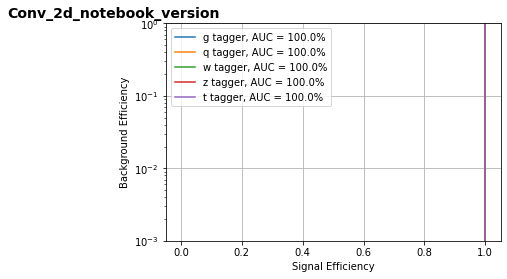

In [11]:
if 'j_index' in labels: labels.remove('j_index')

predict_test = model.predict(X_test)

df = pd.DataFrame()

fpr = {}
tpr = {}
auc1 = {}

plt.figure()       
for i, label in enumerate(labels):
    df[label] = y_test[:,i]
    df[label + '_pred'] = predict_test[:,i]

    fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

    auc1[label] = auc(fpr[label], tpr[label])

    plt.plot(tpr[label],fpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
plt.semilogy()
plt.xlabel("Signal Efficiency")
plt.ylabel("Background Efficiency")
plt.ylim(0.001,1)
plt.grid(True)
plt.legend(loc='upper left')
plt.figtext(0.25, 0.90,'Conv_2d_notebook_version',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)

In [21]:
def makeRoc(features_val, labels_val, labels, model, outputDir='', outputSuffix=''):
    from sklearn.metrics import roc_curve, auc
    labels_pred = model.predict(features_val)
    df = pd.DataFrame()
    fpr = {}
    tpr = {}
    auc1 = {}
    plt.figure(figsize=(10,8))       
    for i, label in enumerate(labels):
        df[label] = labels_val[:,i]
        df[label + '_pred'] = labels_pred[:,i]
        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])
        auc1[label] = auc(fpr[label], tpr[label])
        plt.plot(fpr[label],tpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
    plt.plot([0, 1], [0, 1], lw=1, color='black', linestyle='--')
    #plt.semilogy()
    plt.xlabel("Background Efficiency")
    plt.ylabel("Signal Efficiency")
    plt.xlim([-0.05, 1.05])
    plt.ylim(0.001,1.05)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.figtext(0.25, 0.90,'CNN2D Curve',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)
    #plt.figtext(0.35, 0.90,'preliminary', style='italic', wrap=True, horizontalalignment='center', fontsize=14) 
    #plt.savefig('%sROC_%s.pdf'%(outputDir, outputSuffix))
    return labels_pred



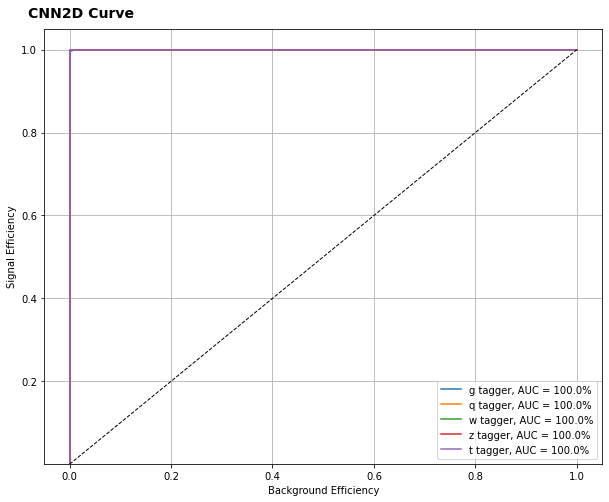

In [22]:
y_pred = makeRoc(X_test, y_test, labels, model, outputSuffix='CNN1D')

In [19]:
def learningCurve(history):
    plt.figure(figsize=(10,8))
    plt.plot(history.history['loss'], linewidth=1)
    plt.plot(history.history['val_loss'], linewidth=1)
    plt.title('Model Loss over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['training sample loss','validation sample loss'])
    #plt.savefig('Learning_curve.pdf')
    plt.show()
    plt.close()

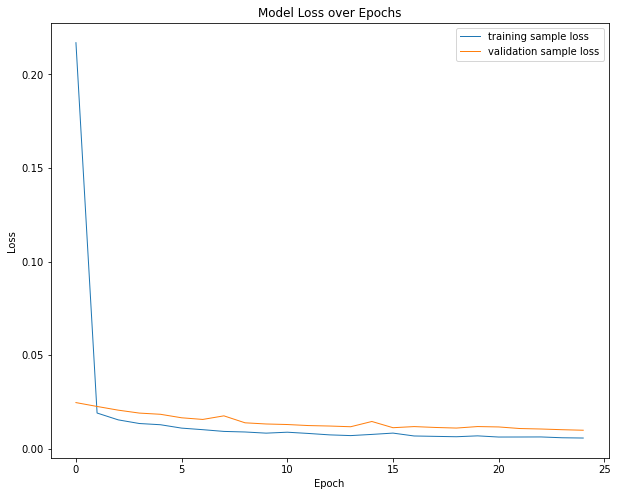

In [20]:
learningCurve(history)